In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc


df = pd.read_csv("myData_glucose_8-14-2024.csv")
df["Device Timestamp"] = pd.to_datetime(df["Device Timestamp"])
df = df[~df["Historic Glucose mg/dL"].isnull()]
df.head()

/var/folders/tf/8zcmjl611pq3yzqnbd6q05fw0000gn/T/ipykernel_33598/1996975524.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("myData_glucose_8-14-2024.csv")


,Device,Serial Number,Device Timestamp,Record Type,Historic Glucose mg/dL,Scan Glucose mg/dL,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin (units),Notes,Strip Glucose mg/dL,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
0,FreeStyle Libre 3,d9f04c33-7ff8-47d7-896e-f379797713f0,2023-05-03 11:37:00,0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FreeStyle Libre 3,d9f04c33-7ff8-47d7-896e-f379797713f0,2023-05-03 11:42:00,0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FreeStyle Libre 3,d9f04c33-7ff8-47d7-896e-f379797713f0,2023-05-03 11:47:00,0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FreeStyle Libre 3,d9f04c33-7ff8-47d7-896e-f379797713f0,2023-05-03 11:52:00,0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FreeStyle Libre 3,d9f04c33-7ff8-47d7-896e-f379797713f0,2023-05-03 11:57:00,0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
def get_walking_glucose_curve(
    data: np.ndarray,
    center: int,
    n_steps_before: int = 4,
    n_steps_after: int = 24,
    return_df: bool = False,
    calc_auc: bool = False,
    count_n: bool = True,
):
    """Builds glucose tolerance curves by systematically walking an array of glucose
    readings which have already been sorted (asc) as a function of time. Once
    a value >= {center} is detected, we slice the array from n steps before
    to n steps after, then resume the walk looking for the next detection of {center}.
    Using these same-shape-same-center arrays, we can then statistically describe
    glycemic control.

    Args:
        data (np.ndarray): A numpy array of glucose readings in mg/dL. It's exepcted
        that the timeseries resolution is 5min, just like readings from a FreeStyle
        Libre.
        center (int): The glucose threshold at which the walking operation is triggered.
        n_steps_before (int, optional): How many steps to evaluate before {center}.
        Defaults to 4 (20 minutes).
        n_steps_after (int, optional): How many steps to evaluate after {center}.
        Defaults to 24 (120 minutes).
        return_df (bool, optional): Whether to return your glycemic matrix.
        Defaults to False.
        calc_auc (bool, optional): Whether to calculate the AUC. NOTE: This will
        be expressed in (mg*H)/L. Defaults to True.
        count_n (bool, optional): Whether to return the count of n curves evaluated.
        Defaults to True.

    Returns:
        result (dict): A dictionary containing everything you need to draw some
        pretty graphs.
        (result, df) (tuple): A tuple containing both the resulting dictionary and
        the glycemic matrix as a pandas dataframe.
    """

    # We'll need a container for our complete arrays
    container = []

    # Then we'll walk a walk along the array, assuming it moves in time from top
    # to bottom
    index = 0

    # While the index we need to evaluate is within the array
    while index < (len(data)):

        # Get the value at index n
        value = data[index]

        # Then, if that value is on "center"
        if value >= center:

            # Check to make sure the previous values in the window are all
            # below the threshold
            if (data[(index - n_steps_before) : index] < center).all():

                # If that's true, we can just grab everything in our desired window
                # of review. NOTE: We need a +1 here to make sure we are always capturing
                # the desired scope of the walk
                arr = data[(index - n_steps_before) : (index + n_steps_after + 1)]

                # And if our array has values for all steps in the given window,
                # add it it our container for extraction
                if len(arr) == n_steps_before + n_steps_after + 1:
                    container.append(arr)

                # Finally, go ahead and move our "next index to look at" to the
                # end of our window
                index += n_steps_after + 1

            # If not all previous values are below the threshold, we need to take
            # a single index walk forward
            else:
                index += 1

        # If we aren't at our desired threshold yet, walk a single index forward
        else:
            index += 1

    # From here, we should have a full matrix of similarly shaped arrays
    # So we'll convert these into a dataframe for easy reference
    df = pd.DataFrame(container)

    # We want to plot data about our quantiles, so this is what we'll actually
    # return
    result = {
        # Quantiles here
        "q_0.05": df.quantile(0.05),
        "q_0.25": df.quantile(0.25),
        "q_0.50": df.quantile(0.50),
        "q_0.75": df.quantile(0.75),
        "q_0.95": df.quantile(0.95),
        # Generate x-ticks values for matplotlib
        "x_ticks": [f"t-{n*5}" for n in list(range(1, n_steps_before + 1))[::-1]]
        + ["t0"]
        + [f"t+{n*5}" for n in range(1, n_steps_after + 1)],
    }

    # Next we have extra behavior if we've expected to calculate the AUC
    # NOTE This is the median AUC, and given that we're using raw data here from
    # the FSL3, we'll need to adjust the units w/ dimensional analysis to get
    # the typical units for a pharmocologic AUC
    if calc_auc:
        auc_x = [5 * n for n in range(n_steps_before + n_steps_after + 1)]
        median_auc = auc(auc_x, result["q_0.50"])  # Unit should be: (mg*min)/dL
        median_auc_corrected = round(
            median_auc * (1 / 60) * (1 / 0.1), 2
        )  # Unit is now (mg*H)/L
        result["auc"] = median_auc

    # If we want to provide the number of observations, we do this here
    if count_n:
        result["n_observations"] = len(df)

    # Hit up our return behaviors
    if return_df:
        return result, df
    else:
        return result

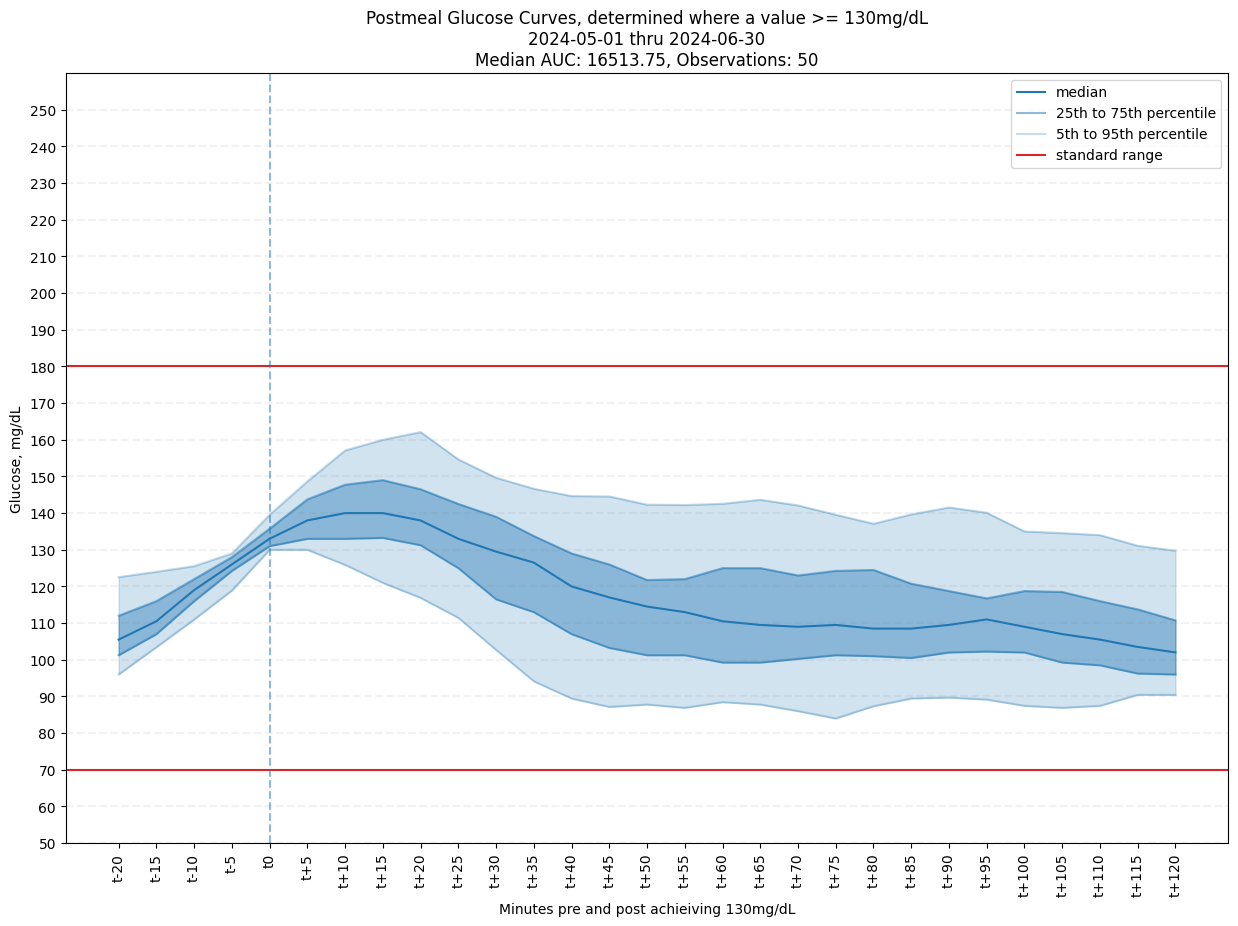

In [3]:
slice = df[df["Device Timestamp"].between("2024-05-01", "2024-06-30")].copy()
r, rdf = get_walking_glucose_curve(
    slice["Historic Glucose mg/dL"].to_numpy(),
    130,
    return_df=True,
    calc_auc=True,
    count_n=True,
)

# Get the AUC and count of curves
observed_auc = r["auc"]
n_curves = r["n_observations"]

plt.figure(figsize=(15, 10))
plt.title(
    "Postmeal Glucose Curves, determined where a value >= 130mg/dL"
    "\n2024-05-01 thru 2024-06-30"
    f"\nMedian AUC: {observed_auc}, Observations: {n_curves}"
)


# Actual curves plotted here, with alphas
plt.plot(r["q_0.05"], color="tab:blue", alpha=0.25)
plt.plot(r["q_0.25"], color="tab:blue", alpha=0.5)
plt.plot(r["q_0.50"], color="tab:blue", label="median")
plt.plot(r["q_0.75"], color="tab:blue", alpha=0.5, label="25th to 75th percentile")
plt.plot(r["q_0.95"], color="tab:blue", alpha=0.25, label="5th to 95th percentile")

# Gradient curves here
plt.fill_between(
    x=range(len(r["q_0.05"])),
    y1=r["q_0.05"],
    y2=r["q_0.95"],
    color="tab:blue",
    alpha=0.20,
)
plt.fill_between(
    x=range(len(r["q_0.05"])),
    y1=r["q_0.25"],
    y2=r["q_0.75"],
    color="tab:blue",
    alpha=0.40,
)

# HLines too add visibility into behavior
[
    plt.axhline(y=i, linestyle="--", color="gray", alpha=0.1)
    for i in range(0, 260)[50:300:10]
]

# Other meaningful HLines and Vlines
plt.axhline(70, color="tab:red", label="standard range")
plt.axhline(180, color="tab:red")
# plt.axhline(130, alpha=0.5, color="tab:blue", linestyle="--")
plt.axvline(4, alpha=0.5, linestyle="--")

# Modify the way data is displayed
plt.ylim((50, 260))
plt.yticks(range(0, 260)[50:300:10])
plt.xticks(ticks=list(range(len(r["x_ticks"]))), labels=r["x_ticks"], rotation=90)

# Legend
plt.xlabel("Minutes pre and post achieiving 130mg/dL")
plt.ylabel("Glucose, mg/dL")
plt.legend()

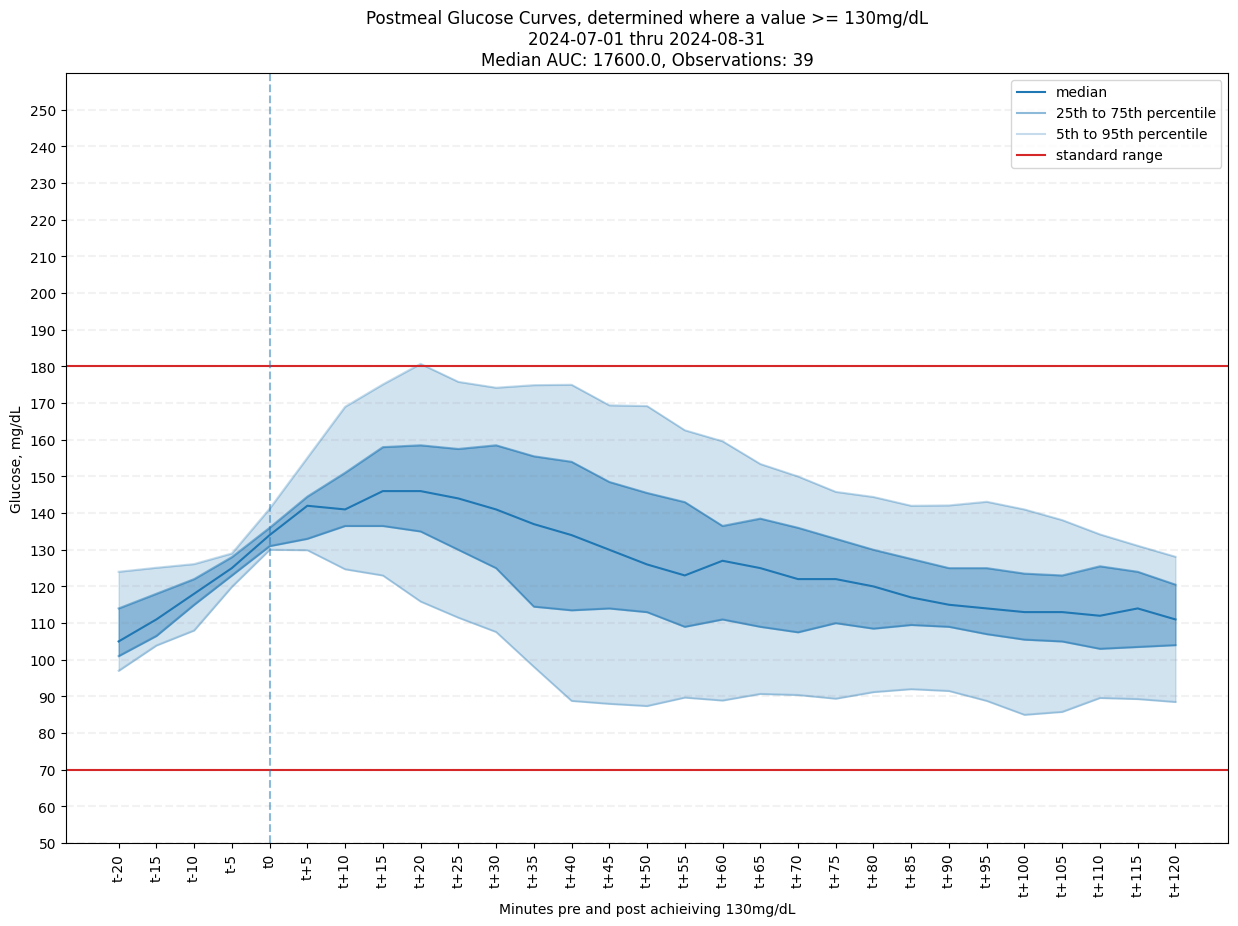

In [4]:
slice2 = df[df["Device Timestamp"].between("2024-07-01", "2024-08-31")].copy()
r, rdf = get_walking_glucose_curve(
    slice2["Historic Glucose mg/dL"].to_numpy(),
    130,
    return_df=True,
    calc_auc=True,
    count_n=True,
)

# Get the AUC and count of curves
observed_auc = r["auc"]
n_curves = r["n_observations"]

plt.figure(figsize=(15, 10))
plt.title(
    "Postmeal Glucose Curves, determined where a value >= 130mg/dL"
    "\n2024-07-01 thru 2024-08-31"
    f"\nMedian AUC: {observed_auc}, Observations: {n_curves}"
)


# Actual curves plotted here, with alphas
plt.plot(r["q_0.05"], color="tab:blue", alpha=0.25)
plt.plot(r["q_0.25"], color="tab:blue", alpha=0.5)
plt.plot(r["q_0.50"], color="tab:blue", label="median")
plt.plot(r["q_0.75"], color="tab:blue", alpha=0.5, label="25th to 75th percentile")
plt.plot(r["q_0.95"], color="tab:blue", alpha=0.25, label="5th to 95th percentile")

# Gradient curves here
plt.fill_between(
    x=range(len(r["q_0.05"])),
    y1=r["q_0.05"],
    y2=r["q_0.95"],
    color="tab:blue",
    alpha=0.20,
)
plt.fill_between(
    x=range(len(r["q_0.05"])),
    y1=r["q_0.25"],
    y2=r["q_0.75"],
    color="tab:blue",
    alpha=0.40,
)

# HLines too add visibility into behavior
[
    plt.axhline(y=i, linestyle="--", color="gray", alpha=0.1)
    for i in range(0, 260)[50:300:10]
]

# Other meaningful HLines and Vlines
plt.axhline(70, color="tab:red", label="standard range")
plt.axhline(180, color="tab:red")
# plt.axhline(130, alpha=0.5, color="tab:blue", linestyle="--")
plt.axvline(4, alpha=0.5, linestyle="--")

# Modify the way data is displayed
plt.ylim((50, 260))
plt.yticks(range(0, 260)[50:300:10])
plt.xticks(ticks=list(range(len(r["x_ticks"]))), labels=r["x_ticks"], rotation=90)

# Legend
plt.xlabel("Minutes pre and post achieiving 130mg/dL")
plt.ylabel("Glucose, mg/dL")
plt.legend()